In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import eurostat
import numpy as np
from tqdm import tqdm
from pmdarima.arima import auto_arima
import warnings
import pickle
import xgboost as xgb
from sklearn.metrics  import mean_squared_error as mse_score

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from statsmodels.tsa.statespace.sarimax import SARIMAX


from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt

from sklearn.model_selection import GridSearchCV
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error as mape_score
from sklearn.metrics import r2_score
from joblib import Parallel
from joblib import delayed
from os import cpu_count

from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM, InputLayer
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsolutePercentageError
from tensorflow.keras.optimizers import Adam

# Interactive widgets
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Show all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr" # change to all, to show all

In [107]:
with open('tsfinal.pickle', 'rb') as f:
    tsfinal = pickle.load(f)
tsprod= tsfinal["prod"]
tsfeed= tsfinal["feed"]
tscrops= tsfinal["crops"]


In [121]:
with open('arima_forecast_crops.pickle', 'rb') as f:
    forecast_crops = pickle.load(f)
forecast_crops["Beet"]["FR"]["Forecast"]

18    167.804788
19    155.863760
20    152.088374
21    150.894714
22    150.517315
23    150.397993
24    150.360267
25    150.348339
26    150.344568
27    150.343376
28    150.342999
29    150.342879
30    150.342842
31    150.342830
32    150.342826
33    150.342825
34    150.342824
35    150.342824
Name: predicted_mean, dtype: float64

# Feedstock Prices


In [108]:
with open('arima_forecast_feed.pickle', 'rb') as f:
    feed_arima = pickle.load(f)

feed_arima.keys()

dict_keys(['Maize', 'Wheat', 'Beet'])

In [109]:
with open('arima_forecast_feed.pickle', 'rb') as f:
    feed_arima = pickle.load(f)

feed_arima.keys()

with open('lstm_forecast_feed.pickle', 'rb') as f:
    feed_lstm = pickle.load(f)

feed_lstm.keys()

dict_keys(['Maize', 'Wheat', 'Beet'])

In [110]:
len(feed_lstm["Maize"]["BE"]["test"]) + len(feed_lstm["Maize"]["BE"]["train"])

413

In [111]:
len(tsfeed["Maize"]["BE"].Price)

425

In [112]:
tsfeed["Maize"]["BE"].Price

TIME_PERIOD
1988-01-01    157.741949
1988-02-01    162.184176
1988-03-01    158.356818
1988-04-01    155.518185
1988-05-01    173.189180
                 ...    
2023-01-01    273.821394
2023-02-01    159.411978
2023-03-01    154.392259
2023-04-01    145.872458
2023-05-01    140.494315
Name: Price, Length: 425, dtype: float64

In [113]:
test = feed_arima["Maize"]["BE"]["Forecast"]
test_arima = test[test.index <= "2023-05-01"]
test_arima

2016-05-01    165.405227
2016-06-01    166.967933
2016-07-01    168.807740
2016-08-01    169.225076
2016-09-01    170.556791
                 ...    
2023-01-01    177.663371
2023-02-01    178.795577
2023-03-01    177.588962
2023-04-01    178.369506
2023-05-01    177.532506
Freq: MS, Name: predicted_mean, Length: 85, dtype: float64

In [114]:
test_lstm = feed_lstm["Maize"]["BE"]["predictions"][len(feed_lstm["Maize"]["BE"]["train"]):len(feed_lstm["Maize"]["BE"]["test"]) + len(feed_lstm["Maize"]["BE"]["train"])]
test_lstm.index = test_arima.index
test_lstm

2016-05-01    160.947077
2016-06-01    163.558273
2016-07-01    166.257642
2016-08-01    168.380681
2016-09-01    170.763514
                 ...    
2023-01-01    246.121763
2023-02-01    258.783487
2023-03-01    262.582931
2023-04-01    264.107248
2023-05-01    254.355528
Freq: MS, Name: Prediction, Length: 85, dtype: float64

In [115]:

mape_arima = feed_arima["Maize"]["BE"]["MAPE"]
mape_lstm = feed_lstm["Maize"]["BE"]["test_mape"]
sum_factors = (1/mape_arima)+ (1/mape_lstm)
weight_arima = (1/mape_arima) / sum_factors
weight_lstm = (1/mape_lstm) / sum_factors

fusion = test_arima * weight_arima + test_lstm * weight_lstm
fusion_mape = round(mape_score(feed_lstm["Maize"]["BE"]["test"].values, fusion.values) *100, 2)
print(fusion_mape)
print(fusion)

28.78
2016-05-01    163.213908
2016-06-01    165.291980
2016-07-01    167.554288
2016-08-01    168.810030
2016-09-01    170.658402
                 ...    
2023-01-01    211.312797
2023-02-01    218.112119
2023-03-01    219.366137
2023-04-01    220.512269
2023-05-01    215.293407
Freq: MS, Length: 85, dtype: float64


In [116]:
ts = tsfeed["Maize"]["ES"].Price
len(ts[ts.index < "1998"] - 12)

54

In [117]:
fusion_feed = {}
fusion_results = {}
for p in tsfeed.keys():
    fusion_results[p]={}
    for geo in tsfeed[p].keys():
        test = feed_arima[p][geo]["Forecast"]
        test_arima = test[test.index <= "2023-05-01"]
        forecast_arima = feed_arima[p][geo]["Forecast"][feed_arima[p][geo]["Forecast"].index > "2023-05-01"]
        forecast_lstm = feed_lstm[p][geo]["forecast"][:len(forecast_arima)]
        forecast_lstm.index = forecast_arima.index
        if p == "Maize" and geo == "ES":
            test_lstm = feed_lstm[p][geo]["predictions"][len(feed_lstm[p][geo]["train"])-1:len(feed_lstm[p][geo]["test"]) + len(feed_lstm[p][geo]["train"])]
        elif p == "Beet" and geo == "ES":
            test_lstm = feed_lstm[p][geo]["predictions"][len(feed_lstm[p][geo]["train"])-20:len(feed_lstm[p][geo]["test"]) + len(feed_lstm[p][geo]["train"])]
        else:
            test_lstm = feed_lstm[p][geo]["predictions"][len(feed_lstm[p][geo]["train"]):len(feed_lstm[p][geo]["test"]) + len(feed_lstm[p][geo]["train"])]
        test_lstm.index = test_arima.index
        mape_arima = feed_arima[p][geo]["MAPE"]
        mape_lstm = feed_lstm[p][geo]["test_mape"]
        sum_factors = (1/mape_arima)+ (1/mape_lstm)
        weight_arima = (1/mape_arima) / sum_factors
        weight_lstm = (1/mape_lstm) / sum_factors

        fusion = test_arima * weight_arima + test_lstm * weight_lstm

        forecast = forecast_arima * weight_arima + forecast_lstm * weight_lstm
        fusion_results[p][geo] = forecast
        if p == "Maize" and geo == "ES":
            fusion_mape = round(mape_score(feed_lstm[p][geo]["test"].values, fusion.values[1:]) *100, 2)
        elif p == "Beet" and geo == "ES":
            fusion_mape = round(mape_score(list(feed_lstm[p][geo]["train"].values[-19:]) + (list(feed_lstm[p][geo]["test"].values)), fusion.values[1:]) *100, 2) 
        else:
            fusion_mape = round(mape_score(feed_lstm[p][geo]["test"].values, fusion.values) *100, 2) 
        fusion_feed[(p, geo)] = fusion_mape, (round(weight_arima, 2), round(weight_lstm, 2)), (mape_arima, mape_lstm)
fusion_feed

{('Maize', 'BE'): (28.78, (0.51, 0.49), (29.6, 30.62)),
 ('Maize', 'ES'): (40.62, (0.36, 0.64), (70.94, 40.67)),
 ('Maize', 'FR'): (107.77, (0.29, 0.71), (192.79, 77.9)),
 ('Wheat', 'BE'): (10.98, (0.46, 0.54), (12.65, 10.8)),
 ('Wheat', 'ES'): (15.97, (0.58, 0.42), (16.58, 23.37)),
 ('Wheat', 'FR'): (17.98, (0.58, 0.42), (16.65, 22.56)),
 ('Beet', 'BE'): (30.46, (0.66, 0.34), (24.43, 47.41)),
 ('Beet', 'ES'): (243.77, (0.47, 0.53), (212.27, 189.21)),
 ('Beet', 'FR'): (19.61, (0.47, 0.53), (21.91, 19.35))}

In [155]:
forecast_crops["Beet"]["FR"]["Forecast"]

18    167.804788
19    155.863760
20    152.088374
21    150.894714
22    150.517315
23    150.397993
24    150.360267
25    150.348339
26    150.344568
27    150.343376
28    150.342999
29    150.342879
30    150.342842
31    150.342830
32    150.342826
33    150.342825
34    150.342824
35    150.342824
Name: predicted_mean, dtype: float64

In [163]:
ts_ftons = {}
ts_fprice = {}
for p in fusion_results.keys():
    ts_ftons[p] = {}
    ts_fprice[p] = {}
    for geo in fusion_results[p].keys():
        #price
        ts = fusion_results[p][geo]
        ts = ts[(ts.index >= "2024") & (ts.index < "2034")]
        ts_fprice[p][geo] = ts.copy()


        #qty
        qty = ts.copy()
        qty = pd.DataFrame(qty)
        qty["year"] = qty.index.year.astype(int) - 2000
        qty = qty.rename(columns ={0:"Value"})
        #f = pd.DataFrame(forecast_crops[p][geo]["Forecast"])
        df = pd.DataFrame(qty)
        tt = df['year'].map(forecast_crops[p][geo]["Forecast"])
        tt = tt/ 12 * 10**6
        ts_ftons[p][geo] = tt.copy()
        # price

with open('fusion_forecast_feed_price.pickle', 'wb') as f:
    pickle.dump(ts_fprice, f)
with open('fusion_forecast_feed_tons.pickle', 'wb') as f:
    pickle.dump(ts_ftons, f)
with open('fusion_forecast_feed_price.pickle', 'rb') as f:
    ts_ftons = pickle.load(f)
ts_ftons["Beet"]["FR"]

2024-01-01    261.966407
2024-02-01    259.440878
2024-03-01    260.976660
2024-04-01    258.342779
2024-05-01    255.227361
                 ...    
2033-08-01    142.337920
2033-09-01    142.218417
2033-10-01    142.103618
2033-11-01    141.993331
2033-12-01    141.887366
Freq: MS, Length: 120, dtype: float64

In [ ]:
with open('fusion_forecast_feed_price.pickle', 'rb') as f:
    fp = pickle.load(f)
with open('fusion_forecast_feed_tons.pickle', 'rb') as f:
    ft = pickle.load(f)
with open('fusion_forecast_prod_price.pickle', 'rb') as f:
    pp = pickle.load(f)
with open('fusion_forecast_prod_tons.pickle', 'rb') as f:
    pt = pickle.load(f)

# Product Prices and Quantities

In [7]:
with open('arima_forecast_prod_price.pickle', 'rb') as f:
    prod_arima = pickle.load(f)

with open('lstm_results_prods_price.pickle', 'rb') as f:
    prod_lstm = pickle.load(f)

prod_lstm.keys()

dict_keys(['LA', 'Ethanol', 'SA'])

In [8]:
p = "LA"
geo ="BE"

print(prod_lstm[p][geo].keys())
print(prod_arima[p][geo].keys())
tsprod[p][geo].Tons.head()

dict_keys(['train', 'val', 'test', 'predictions', 'forecast', 'train_mape', 'val_mape', 'test_mape'])
dict_keys(['Forecast', 'MAPE'])


TIME_PERIOD
1988-01-01    65.9
1988-02-01    79.6
1988-03-01    61.8
1988-04-01    49.2
1988-05-01    99.2
Name: Tons, dtype: float64

In [9]:
pd.concat((prod_lstm[p][geo]["train"], prod_lstm[p][geo]["test"]))

0      1444.029680
1      1339.899371
2      1657.182911
3      1534.312500
4      1567.954802
          ...     
408    2158.146055
409    2126.812785
410    1928.465241
411    1894.565260
412    2027.749651
Name: Actuals, Length: 413, dtype: float64

In [10]:
prod_lstm[p][geo]["predictions"]

0      1462.983169
1      1432.394892
2      1453.371506
3      1466.556325
4      1466.586364
          ...     
408    1717.992905
409    1757.917896
410    1799.521910
411    1829.993201
412    1846.132558
Name: Prediction, Length: 413, dtype: float64

In [11]:
prod_lstm[p][geo]["test"]

328    1149.015221
329    1231.584633
330    1273.254976
331    1177.251426
332    1260.828071
          ...     
408    2158.146055
409    2126.812785
410    1928.465241
411    1894.565260
412    2027.749651
Name: Actuals, Length: 85, dtype: float64

In [105]:
with open('arima_forecast_prod_price.pickle', 'rb') as f:
    prod_arima = pickle.load(f)

with open('lstm_results_prods_price.pickle', 'rb') as f:
    prod_lstm = pickle.load(f)

field = "Price"

fusion_forecast_price = {}
fusion_test_price = {}

k = {}
for p in prod_lstm.keys():
    fusion_forecast_price[p] = {}
    fusion_test_price[p] = {}
    for geo in prod_lstm[p].keys():
        original = tsprod[p][geo][field]

        arima = prod_arima[p][geo]["Forecast"]


        forecast_arima = arima[arima.index > "2023-05-01"]
        forecast_lstm = prod_lstm[p][geo]["forecast"][:len(forecast_arima)]
        forecast_lstm.index = forecast_arima.index

        test_arima = arima[arima.index <= "2023-05-01"]
        test_original = original[-len(test_arima):]
        test_lstm = prod_lstm[p][geo]["predictions"][-len(test_arima):]
        test_lstm.index = test_arima.index




        mape_arima = prod_arima[p][geo]["MAPE"]
        mape_lstm = prod_lstm[p][geo]["test_mape"]
        sum_factors = (1/mape_arima)+ (1/mape_lstm)
        weight_arima = (1/mape_arima) / sum_factors
        weight_lstm = (1/mape_lstm) / sum_factors

        test_fusion = test_arima * weight_arima + test_lstm * weight_lstm
        forecast_fusion = forecast_arima * weight_arima + forecast_lstm * weight_lstm

        fusion_forecast_price[p][geo] = forecast_fusion
        fusion_test_price[p][geo] = test_fusion

        mape_fusion = round(mape_score(test_original.values, test_fusion.values) *100, 2) 
        print(f"{p, geo} | Fusion MAPE: {mape_fusion}% {(mape_arima, mape_lstm)}, Forecast: {len(forecast_arima), len(forecast_lstm)}, Test: {len(test_arima), len(test_lstm), len(test_original)}")

        k[f"{p}-{geo}"] = 0


('LA', 'BE') | Fusion MAPE: 12.67% (14.4, 11.59), Forecast: (130, 130), Test: (85, 85, 85)
('LA', 'DE') | Fusion MAPE: 9.56% (11.97, 8.15), Forecast: (130, 130), Test: (85, 85, 85)
('LA', 'NL') | Fusion MAPE: 15.02% (15.65, 25.57), Forecast: (130, 130), Test: (85, 85, 85)
('Ethanol', 'DE') | Fusion MAPE: 9.85% (13.05, 10.78), Forecast: (130, 130), Test: (85, 85, 85)
('Ethanol', 'FR') | Fusion MAPE: 15.32% (16.58, 17.0), Forecast: (130, 130), Test: (85, 85, 85)
('Ethanol', 'NL') | Fusion MAPE: 18.92% (16.1, 26.27), Forecast: (130, 130), Test: (85, 85, 85)
('SA', 'DE') | Fusion MAPE: 15.33% (13.67, 10.98), Forecast: (130, 130), Test: (85, 85, 85)
('SA', 'IT') | Fusion MAPE: 18.39% (16.21, 14.52), Forecast: (130, 130), Test: (85, 85, 85)
('SA', 'NL') | Fusion MAPE: 16.82% (17.65, 13.08), Forecast: (130, 130), Test: (85, 85, 85)


In [87]:
@interact
def fusion_plot(Dataset = list(k.keys())):
    p = Dataset.split("-")[0]
    geo = Dataset.split("-")[1]
    field = "Price"

    original = tsprod[p][geo][field]

    arima = prod_arima[p][geo]["Forecast"]

    forecast_arima = arima[arima.index > "2023-05-01"]
    forecast_lstm = prod_lstm[p][geo]["forecast"][:len(forecast_arima)]
    forecast_lstm.index = forecast_arima.index

    test_arima = arima[arima.index <= "2023-05-01"]
    test_original = original[-len(test_arima):]
    test_lstm = prod_lstm[p][geo]["predictions"][-len(test_arima):]
    test_lstm.index = test_arima.index

    mape_arima = prod_arima[p][geo]["MAPE"]
    mape_lstm = prod_lstm[p][geo]["test_mape"]
    sum_factors = (1/mape_arima)+ (1/mape_lstm)
    weight_arima = (1/mape_arima) / sum_factors
    weight_lstm = (1/mape_lstm) / sum_factors

    test_fusion = test_arima * weight_arima + test_lstm * weight_lstm
    forecast_fusion = forecast_arima * weight_arima + forecast_lstm * weight_lstm

    fusion_forecast_price[p][geo] = forecast_fusion
    fusion_test_price[p][geo] = test_fusion

    mape_fusion = round(mape_score(test_original.values, test_fusion.values) *100, 2) 

    lstm = pd.concat([test_lstm, forecast_lstm]) 
    fusion = pd.concat([test_fusion, forecast_fusion]) 


    fig, ax = plt.subplots(figsize = (12, 6))
    ax.plot(original, label = "Historical")
    ax.plot(fusion, label = f"Fusion ({mape_fusion}%)")
    ax.plot(arima, label = f"Arima ({mape_arima}%)")
    ax.plot(lstm, label = f"LSTM ({mape_lstm}%)")

    plt.legend()
    plt.title(f"Forecast Comparison: Price of {p} in {geo} (€/ton)")
    plt.show()

interactive(children=(Dropdown(description='Dataset', options=('LA-BE', 'LA-DE', 'LA-NL', 'Ethanol-DE', 'Ethan…

In [13]:
fusion_forecast_price['LA']['BE']

2023-06-01    1557.885244
2023-07-01    1555.201221
2023-08-01    1548.787059
2023-09-01    1542.024256
2023-10-01    1532.775988
                 ...     
2033-11-01    1268.672153
2033-12-01    1272.419426
2034-01-01    1273.262318
2034-02-01    1274.225762
2034-03-01    1274.663931
Freq: MS, Length: 130, dtype: float64

In [157]:
with open('arima_forecast_prod_qty.pickle', 'rb') as f:
    prod_arima = pickle.load(f)

with open('lstm_results_prods_tons.pickle', 'rb') as f:
    prod_lstm = pickle.load(f)

field = "Tons"

fusion_forecast_tons = {}

for p in prod_lstm.keys():
    fusion_forecast_tons[p] = {}
    for geo in prod_lstm[p].keys():
        original = tsprod[p][geo][field]

        arima = prod_arima[p][geo]["Forecast"]


        forecast_arima = arima[arima.index > "2023-05-01"]
        forecast_lstm = prod_lstm[p][geo]["forecast"][:len(forecast_arima)]
        forecast_lstm.index = forecast_arima.index

        test_arima = arima[arima.index <= "2023-05-01"]
        test_original = original[-len(test_arima):]
        test_lstm = prod_lstm[p][geo]["predictions"][-len(test_arima):]
        test_lstm.index = test_arima.index

        mape_arima = prod_arima[p][geo]["MAPE"]
        mape_lstm = prod_lstm[p][geo]["test_mape"]
        sum_factors = (1/mape_arima)+ (1/mape_lstm)
        weight_arima = (1/mape_arima) / sum_factors
        weight_lstm = (1/mape_lstm) / sum_factors

        test_fusion = test_arima * weight_arima + test_lstm * weight_lstm
        forecast_fusion = forecast_arima * weight_arima + forecast_lstm * weight_lstm
        
        fusion_forecast_tons[p][geo] = forecast_fusion

        mape_fusion = round(mape_score(test_original.values, test_fusion.values) *100, 2) 
        print(f"{p, geo} | Fusion MAPE: {mape_fusion}% {(mape_arima, mape_lstm)}, Forecast: {len(forecast_arima), len(forecast_lstm)}, Test: {len(test_arima), len(test_lstm), len(test_original)}")


('LA', 'BE') | Fusion MAPE: 16.07% (17.43, 15.54), Forecast: (130, 130), Test: (85, 85, 85)
('LA', 'DE') | Fusion MAPE: 9.17% (8.87, 10.41), Forecast: (130, 130), Test: (85, 85, 85)
('LA', 'NL') | Fusion MAPE: 39.0% (35.88, 46.61), Forecast: (130, 130), Test: (85, 85, 85)
('Ethanol', 'DE') | Fusion MAPE: 11.59% (11.78, 17.79), Forecast: (130, 130), Test: (85, 85, 85)
('Ethanol', 'FR') | Fusion MAPE: 31.02% (38.66, 22.06), Forecast: (130, 130), Test: (85, 85, 85)
('Ethanol', 'NL') | Fusion MAPE: 17.05% (17.01, 17.48), Forecast: (130, 130), Test: (85, 85, 85)
('SA', 'DE') | Fusion MAPE: 16.95% (18.45, 18.53), Forecast: (130, 130), Test: (85, 85, 85)
('SA', 'IT') | Fusion MAPE: 26.82% (21.38, 11.43), Forecast: (130, 130), Test: (85, 85, 85)
('SA', 'NL') | Fusion MAPE: 24.8% (34.28, 21.62), Forecast: (130, 130), Test: (85, 85, 85)


In [97]:
@interact
def fusion_plot(Dataset = list(k.keys())):
    p = Dataset.split("-")[0]
    geo = Dataset.split("-")[1]
    field = "Tons"

    original = tsprod[p][geo][field]

    arima = prod_arima[p][geo]["Forecast"]

    forecast_arima = arima[arima.index > "2023-05-01"]
    forecast_lstm = prod_lstm[p][geo]["forecast"][:len(forecast_arima)]
    forecast_lstm.index = forecast_arima.index

    test_arima = arima[arima.index <= "2023-05-01"]
    test_original = original[-len(test_arima):]
    test_lstm = prod_lstm[p][geo]["predictions"][-len(test_arima):]
    test_lstm.index = test_arima.index

    mape_arima = prod_arima[p][geo]["MAPE"]
    mape_lstm = prod_lstm[p][geo]["test_mape"]
    sum_factors = (1/mape_arima)+ (1/mape_lstm)
    weight_arima = (1/mape_arima) / sum_factors
    weight_lstm = (1/mape_lstm) / sum_factors

    test_fusion = test_arima * weight_arima + test_lstm * weight_lstm
    forecast_fusion = forecast_arima * weight_arima + forecast_lstm * weight_lstm

    fusion_forecast_price[p][geo] = forecast_fusion
    fusion_test_price[p][geo] = test_fusion

    mape_fusion = round(mape_score(test_original.values, test_fusion.values) *100, 2) 

    lstm = pd.concat([test_lstm, forecast_lstm]) 
    fusion = pd.concat([test_fusion, forecast_fusion]) 


    fig, ax = plt.subplots(figsize = (12, 6))
    ax.plot(original, label = "Historical")
    ax.plot(fusion, label = f"Fusion ({mape_fusion}%)")
    ax.plot(arima, label = f"Arima ({mape_arima}%)")
    ax.plot(lstm, label = f"LSTM ({mape_lstm}%)")

    plt.legend()
    plt.title(f"Forecast Comparison: Qty of {p} in {geo} (tons)")
    plt.show()

interactive(children=(Dropdown(description='Dataset', options=('LA-BE', 'LA-DE', 'LA-NL', 'Ethanol-DE', 'Ethan…

In [96]:
tsprod["Ethanol"]["NL"]["Tons"] = ts

In [16]:
market = {}
for p in prod_lstm.keys():
    m_forecast = 0
    m_history = 0
    for geo in prod_lstm[p].keys():
        m_history += tsprod[p][geo].Price *  tsprod[p][geo].Tons
        m_forecast += fusion_forecast_price[p][geo] * fusion_forecast_tons[p][geo]
    market[p] = pd.concat([m_history, m_forecast])

In [17]:
def CAGR(p, y1, y2):
    ds = market[p].groupby(market[p].index.year).sum()
    cagr = round(((ds[y2] / ds[y1])**(1/(y2-y1-1))-1) * 100, 2)
    return cagr

CAGR("LA", 2023, 2030)


2.82

In [18]:
CAGR("Ethanol", 2020, 2027)

4.3

In [19]:
CAGR("SA", 2021, 2030)

-0.79

In [49]:
@interact
def plot_cagr(Product = list(market.keys())):

    ds = market[Product].groupby(market[p].index.year).sum()
    ds.index = ds.index.astype(int)
    ds = ds[(ds.index >= 2015) & (ds.index < 2034)]
    ds = ds/(10**6)
    ds = ds.astype(int)
    fig, ax = plt.subplots(figsize=(10, 6))
    # All bars
    ax.bar(ds.index, ds.values, color="#23708a", label="Historic Values")

    # Bars from 2023 onwards (overwriting the previous bars where the condition is true)
    ax.bar(ds[ds.index >= 2023].index, ds[ds.index >= 2023].values, color="#4f9f8d", label="Forecast")

    # Adding labels and title (optional)
    ax.set_xlabel('Year')
    ax.set_ylabel('Value (M€)')
    ax.set_title(f'Total Market Value for {Product} (CAGR: {CAGR(Product, 2023, 2033)}%)')
    ax.legend()
    ax.set_xticks([int(x) for x in ds.index])
    plt.xticks(rotation=90)
    ax.bar_label(ax.containers[0])


    # Show the plot
    plt.show()


interactive(children=(Dropdown(description='Product', options=('LA', 'Ethanol', 'SA'), value='LA'), Output()),…

# Save File

In [160]:
ts_ptons = {}
ts_pprice = {}
for p in fusion_forecast_tons.keys():
    ts_ptons[p] = {}
    ts_pprice[p] = {}
    for geo in fusion_forecast_tons[p].keys():
        ts = fusion_forecast_tons[p][geo]
        ts = ts[(ts.index >= "2024") & (ts.index < "2034")]
        ts_ptons[p][geo] = ts.copy()
        ts = fusion_forecast_price[p][geo]
        ts = ts[(ts.index >= "2024") & (ts.index < "2034")]
        ts_pprice[p][geo] = ts.copy()

with open('fusion_forecast_prod_price.pickle', 'wb') as f:
    pickle.dump(ts_pprice, f)
with open('fusion_forecast_prod_tons.pickle', 'wb') as f:
    pickle.dump(ts_ptons, f)
with open('fusion_forecast_prod_tons.pickle', 'rb') as f:
    ts_ptons = pickle.load(f)
ts_ptons["Ethanol"]["DE"]

2024-01-01     99746.893494
2024-02-01    100200.007162
2024-03-01    100807.303578
2024-04-01    101191.013284
2024-05-01    101665.222557
                  ...      
2033-08-01    123221.686434
2033-09-01    123461.212068
2033-10-01    123564.750612
2033-11-01    123739.125074
2033-12-01    123857.824788
Freq: MS, Length: 120, dtype: float64

In [162]:
with open('fusion_forecast_prod_price.pickle', 'rb') as f:
    ts_ptons = pickle.load(f)
ts_ptons["Ethanol"]["DE"]

2024-01-01    995.803794
2024-02-01    993.355790
2024-03-01    986.360914
2024-04-01    976.010447
2024-05-01    969.402531
                 ...    
2033-08-01    917.820091
2033-09-01    918.854412
2033-10-01    920.055856
2033-11-01    922.244829
2033-12-01    924.865575
Freq: MS, Length: 120, dtype: float64

In [4]:
ts = tsprod["Ethanol"]["DE"].Tons
ts = smooth(ts)
train, test = split(ts)
train.tail()

TIME_PERIOD
2016-02-01    78004.337167
2016-03-01    78230.437167
2016-04-01    78428.281917
2016-05-01    79256.266667
2016-06-01    78222.831083
Name: Tons, dtype: float64

In [5]:
tsprod["Ethanol"]["DE"].Price

TIME_PERIOD
1988-01-01     537.089447
1988-02-01     479.691552
1988-03-01     530.828307
1988-04-01     512.240225
1988-05-01     483.517450
                 ...     
2023-01-01    1117.564392
2023-02-01    1167.000745
2023-03-01    1298.289840
2023-04-01    1186.485003
2023-05-01    1052.608285
Name: Price, Length: 425, dtype: float64

### Experiment

In [47]:
def df_to_X_y(df, window_size = 24):
    df_as_np = df#.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)- window_size):
        row = [a for a in df_as_np[i: i + window_size]]
        X.append(row)
        label = df_as_np[i + window_size]
        y.append(label)
    return np.array(X), np.array(y)

df = tsprod["Ethanol"]["DE"]

window_size = 12 
period_test = int(0.2*len(df))

scaler = MinMaxScaler()
X, y = df_to_X_y(scaler.fit_transform(df.Price.values.reshape(-1,1)), window_size= window_size)

X_train, y_train = X[:-2*period_test], y[:-2*period_test]
X_val, y_val = X[-2*period_test:-period_test], y[-2*period_test:-period_test]
X_test, y_test = X[-period_test:], y[-period_test:]
#print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

model = Sequential()
model.add(InputLayer((window_size, 1)))
model.add(LSTM(64, input_shape=(window_size, 1), return_sequences=True))
model.add(LSTM(64,input_shape=(window_size, 1)))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))

#cp = ModelCheckpoint('model/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=MeanAbsolutePercentageError())


model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50
           #,callbacks=[cp]
           , verbose=None
          )

train_predictions = model.predict(X_train, verbose=None)
train_res = pd.DataFrame(data={'Prediction': list(train_predictions.flatten()), 'Actuals': y_train.flatten()})
train_res = pd.DataFrame(scaler.inverse_transform(train_res), columns = ['Prediction', 'Actuals'])
train_mape = round(np.mean(np.abs((train_res.Actuals - train_res.Prediction)/train_res.Actuals * 100)), 2)
val_predictions = model.predict(X_val, verbose=None)
val_res = pd.DataFrame(data={'Prediction': list(val_predictions.flatten()), 'Actuals': y_val.flatten()})
val_res = pd.DataFrame(scaler.inverse_transform(val_res), columns = ['Prediction', 'Actuals'])
val_mape = round(np.mean(np.abs((val_res.Actuals - val_res.Prediction)/val_res.Actuals * 100)), 2)
test_predictions = model.predict(X_test, verbose=None)
test_res = pd.DataFrame(data={'Prediction': list(test_predictions.flatten()), 'Actuals': y_test.flatten()})
test_res = pd.DataFrame(scaler.inverse_transform(test_res), columns = ['Prediction', 'Actuals'])
test_mape = round(np.mean(np.abs((test_res.Actuals - test_res.Prediction)/test_res.Actuals*100)), 2)
lstm_df = pd.concat([train_res, val_res, test_res]).reset_index(drop=True)

## Out of Sample Forecast

# Example: Forecasting 100 future time steps
num_forecast_steps = 135

# Create an empty list to store the forecasted values
forecasted_values = []

# Initialize the last known window (X_t) with the last window from the test data
last_known_window = X_test[-1:]

# Perform forecasting for each time step
for i in range(num_forecast_steps):
    # Use the last known window to predict the next time step
    prediction = model.predict(last_known_window, verbose=None)
    
    # Append the forecasted value to the list
    forecasted_values.append(prediction[0, 0])
    
    # Update the last known window (X_t) with the current prediction and shift the window
    last_known_window = np.append(last_known_window[:, 1:, :], np.expand_dims(prediction, axis=1), axis=1)


forecasted_values = scaler.inverse_transform(pd.DataFrame(forecasted_values))
forecast_df = pd.DataFrame({"Forecast" : forecasted_values.flatten()[1:]
                            #,"Lower_CI" : lower_bound_values.flatten()[1:]
                            #,"Upper_CI" :  upper_bound_values.flatten()[1:]
                           })

forecast_df.index = np.array(range(len(lstm_df), len(lstm_df)+ len(forecast_df)))

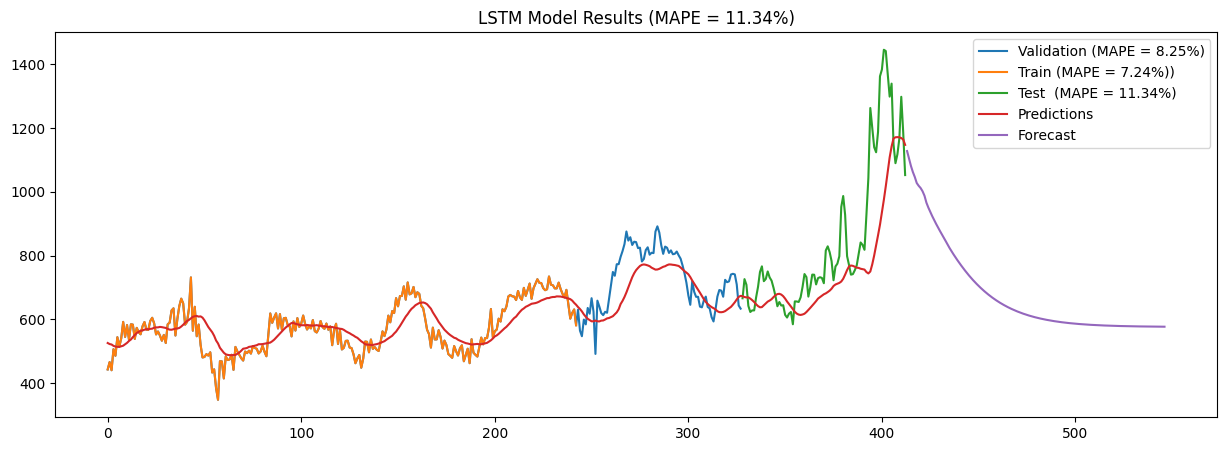

In [48]:
fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(lstm_df[:-period_test].index,lstm_df[:-period_test].Actuals, label = f"Validation (MAPE = {val_mape}%)")
ax.plot(lstm_df[:-2*period_test].index,lstm_df[:-2*period_test].Actuals, label = f"Train (MAPE = {train_mape}%))")
ax.plot(lstm_df[-period_test:].index,lstm_df[-period_test:].Actuals, label = f"Test  (MAPE = {test_mape}%)")
ax.plot(lstm_df.index, lstm_df.Prediction, label = "Predictions")
ax.plot(forecast_df.index, forecast_df.Forecast, label = "Forecast")
plt.legend()
plt.title(f"LSTM Model Results (MAPE = {test_mape}%)")
plt.show()

# Generalization

In [6]:
def df_to_X_y(df, window_size = 24):
    df_as_np = df#.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)- window_size):
        row = [a for a in df_as_np[i: i + window_size]]
        X.append(row)
        label = df_as_np[i + window_size]
        y.append(label)
    return np.array(X), np.array(y)



def run_lstm(
        ts, 
        window_size = 12, 
        ptest = 0.2,
        hidden_units = 64,
        dense_units = 8
        ):
    period_test = int(ptest*len(ts))

    scaler = MinMaxScaler()
    X, y = df_to_X_y(scaler.fit_transform(ts.values.reshape(-1,1)), window_size= window_size)

    X_train, y_train = X[:-2*period_test], y[:-2*period_test]
    X_val, y_val = X[-2*period_test:-period_test], y[-2*period_test:-period_test]
    X_test, y_test = X[-period_test:], y[-period_test:]
    #print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

    model = Sequential()
    model.add(InputLayer((window_size, 1)))
    model.add(LSTM(hidden_units, input_shape=(window_size, 1), return_sequences=True))
    model.add(LSTM(hidden_units,input_shape=(window_size, 1)))
    model.add(Dense(dense_units, 'relu'))
    model.add(Dense(1, 'linear'))

    #cp = ModelCheckpoint('model/', save_best_only=True)
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=MeanAbsolutePercentageError())


    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50
            #,callbacks=[cp]
            , verbose=None
            )

    train_predictions = model.predict(X_train, verbose=None)
    train_res = pd.DataFrame(data={'Prediction': list(train_predictions.flatten()), 'Actuals': y_train.flatten()})
    train_res = pd.DataFrame(scaler.inverse_transform(train_res), columns = ['Prediction', 'Actuals'])
    train_mape = round(np.mean(np.abs((train_res.Actuals - train_res.Prediction)/train_res.Actuals * 100)), 2)
    val_predictions = model.predict(X_val, verbose=None)
    val_res = pd.DataFrame(data={'Prediction': list(val_predictions.flatten()), 'Actuals': y_val.flatten()})
    val_res = pd.DataFrame(scaler.inverse_transform(val_res), columns = ['Prediction', 'Actuals'])
    val_mape = round(np.mean(np.abs((val_res.Actuals - val_res.Prediction)/val_res.Actuals * 100)), 2)
    test_predictions = model.predict(X_test, verbose=None)
    test_res = pd.DataFrame(data={'Prediction': list(test_predictions.flatten()), 'Actuals': y_test.flatten()})
    test_res = pd.DataFrame(scaler.inverse_transform(test_res), columns = ['Prediction', 'Actuals'])
    test_mape = round(np.mean(np.abs((test_res.Actuals - test_res.Prediction)/test_res.Actuals*100)), 2)
    lstm_df = pd.concat([train_res, val_res, test_res]).reset_index(drop=True)

    ## Out of Sample Forecast

    # Example: Forecasting 100 future time steps
    num_forecast_steps = 135

    # Create an empty list to store the forecasted values
    forecasted_values = []

    # Initialize the last known window (X_t) with the last window from the test data
    last_known_window = X_test[-1:]

    # Perform forecasting for each time step
    for i in range(num_forecast_steps):
        # Use the last known window to predict the next time step
        prediction = model.predict(last_known_window, verbose=None)
        
        # Append the forecasted value to the list
        forecasted_values.append(prediction[0, 0])
        
        # Update the last known window (X_t) with the current prediction and shift the window
        last_known_window = np.append(last_known_window[:, 1:, :], np.expand_dims(prediction, axis=1), axis=1)


    forecasted_values = scaler.inverse_transform(pd.DataFrame(forecasted_values))
    forecast_df = pd.DataFrame({"Forecast" : forecasted_values.flatten()[1:]
                                #,"Lower_CI" : lower_bound_values.flatten()[1:]
                                #,"Upper_CI" :  upper_bound_values.flatten()[1:]
                            })

    forecast_df.index = np.array(range(len(lstm_df), len(lstm_df)+ len(forecast_df)))

    results = {}
    results["train"] = lstm_df[:-period_test].Actuals
    results["val"] = lstm_df[:-2*period_test].Actuals
    results["test"] = lstm_df[-period_test:].Actuals
    results["predictions"] = lstm_df.Prediction
    results["forecast"] = forecast_df.Forecast
    results["train_mape"]=train_mape
    results["val_mape"]=val_mape
    results["test_mape"]=test_mape
    return results

In [7]:
ts = tsprod["Ethanol"]["DE"].Price
window_size = 12 
ptest = 0.2

res = run_lstm(ts, window_size)

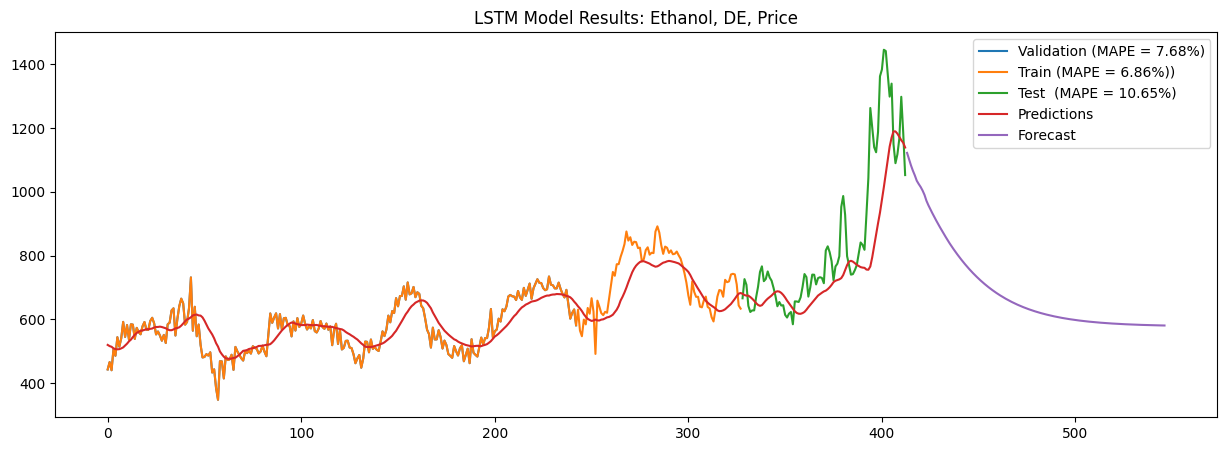

In [8]:
p = "Ethanol"
geo = "DE"
field = "Price"

def plot_res(res, p, geo, field):
    fig, ax = plt.subplots(figsize = (15, 5))
    ax.plot(res["val"].index,res["val"].values, label = f"Validation (MAPE = {res['val_mape']}%)")
    ax.plot(res["train"].index,res["train"].values, label = f"Train (MAPE = {res['train_mape']}%))")
    ax.plot(res["test"].index,res["test"].values, label = f"Test  (MAPE = {res['test_mape']}%)")
    ax.plot(res["predictions"].index,res["predictions"].values, label = "Predictions")
    ax.plot(res["forecast"].index,res["forecast"].values, label = "Forecast")
    plt.legend()
    plt.title(f"LSTM Model Results: {p}, {geo}, {field}")
    plt.show()
plot_res(res, p, geo, field)

In [17]:
window_size = 12 
ptest = 0.2
lstm_results_prods_price = {}
lstm_results_prods_tons = {}
lstm_results_prods = {}
for p in tsprod.keys():
    lstm_results_prods_price[p] = {}
    lstm_results_prods_tons[p] = {}
    for geo in tsprod[p].keys():
        for field in tqdm(["Tons", "Price"]):
            ts = tsprod[p][geo][field]
            res = run_lstm(ts, window_size)
            lstm_results_prods[p,geo,field] = res
            if field == "Price":
                lstm_results_prods_price[p][geo] = res
            elif field == "Tons":
                lstm_results_prods_tons[p][geo] = res

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
@interact
def interact_plots(Dataset = list(lstm_results_prods.keys())):
    res = lstm_results_prods[Dataset]
    p, geo, field = Dataset
    plot_res(res, p, geo, field)

NameError: name 'lstm_results_prods' is not defined

In [12]:
window_size = 12 
ptest = 0.2
lstm_results_feed_price = {}
lstm_results_feed = {}
for p in tsfeed.keys():
    lstm_results_feed_price[p] = {}
    for geo in tqdm(tsfeed[p].keys()):
        ts = tsfeed[p][geo].Price
        res = run_lstm(ts, window_size, hidden_units=64, dense_units=16)
        lstm_results_feed[p,geo,"Price"] = res
        lstm_results_feed_price[p][geo] = res


100%|██████████| 3/3 [00:48<00:00, 16.29s/it]


In [15]:
@interact
def interact_plots(Dataset = list(lstm_results_feed.keys())):
    res = lstm_results_feed[Dataset]
    p, geo, field = Dataset
    print(res["forecast"][-5:])
    plot_res(res, p, geo, field)

interactive(children=(Dropdown(description='Dataset', options=(('Maize', 'BE', 'Price'), ('Maize', 'ES', 'Pric…